In [1]:
import os
import sys 
sys.path.append('../training')
import pickle

from save_data import process_data

import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score

import pandas as pd

# locals
from threshold import ThresholdModel

## Configure

In [2]:
# START_WINDOW = 285
# END_WINDOW = 385

# START_WINDOW = 150
# END_WINDOW = 350

START_WINDOW = 150
END_WINDOW = 550

# START_WINDOW = 0
# END_WINDOW = 770

## Setup data

In [3]:
!mkdir -p models

DATA_IN_DIR = f'../data/raw-data'
DATA_OUT_DIR = f'../data/qick_data/{START_WINDOW}_{END_WINDOW}'
MODEL_DIR = f'models/model_{START_WINDOW}_{END_WINDOW}'

# convert raw ADC data into npy files 
if os.path.exists(f'{DATA_OUT_DIR}/X_train.npy') == False:
    process_data(
        start_window = START_WINDOW, 
        end_window = END_WINDOW, 
        data_in = DATA_IN_DIR,
        data_out = DATA_OUT_DIR
    )

In [4]:
# load data
X_train_val = np.load(os.path.join(DATA_OUT_DIR, f'X_train.npy'))
X_test = np.load(os.path.join(DATA_OUT_DIR, f'X_test.npy'))
y_train_val = np.load(os.path.join(DATA_OUT_DIR, f'y_train.npy'))
y_test = np.load(os.path.join(DATA_OUT_DIR, f'y_test.npy'))

print('Window:')
print('  - Couples I/Q :', (END_WINDOW-START_WINDOW))
print('  - Model inputs:', (END_WINDOW-START_WINDOW)*2)

print('Training:')
print('  - Size        :', X_train_val.shape[0])
print('  - Sample Shape:', X_train_val.shape[1])
print('  - Mean        :', X_train_val.mean())
print('  - Std. Dev.   :', X_train_val.std())

print('Testing:')
print('  - Size        :', X_test.shape[0])
print('  - Sample Shape:', X_test.shape[1])
print('  - Mean        :', X_test.mean())
print('  - Std. Dev.   :', X_test.std())

assert len(X_train_val[0]) == (END_WINDOW-START_WINDOW)*2, 'ERROR: Specified window does not match loaded dataset shape'
assert len(X_test[0]) == (END_WINDOW-START_WINDOW)*2, 'ERROR: Specified window does not match loaded dataset shape'

Window:
  - Couples I/Q : 400
  - Model inputs: 800
Training:
  - Size        : 909000
  - Sample Shape: 800
  - Mean        : -27.76822809130913
  - Std. Dev.   : 1757.2994739291814
Testing:
  - Size        : 101000
  - Sample Shape: 800
  - Mean        : -21.301959876237625
  - Std. Dev.   : 1755.5164879266408


## Load model

In [5]:
MODEL_FILENAME = os.path.join(MODEL_DIR, 'threshold_model.json')
model = ThresholdModel()
model.load(MODEL_FILENAME)

In [6]:
print('=============================Model Summary=============================')
print(f"model.theta: {model.theta}")
print(f"model.threshold: {model.threshold}")
print('=======================================================================')

=============================Model Summary=============================
model.theta: 0.7851534395324336
model.threshold: 309.4620445782748


In [7]:
y_pred = model.predict(X_test)
print('Threshold accuracy: {}, inputs {}, I/Qs {}'.format(accuracy_score(y_test, y_pred), (END_WINDOW-START_WINDOW)*2, (END_WINDOW-START_WINDOW)))

Threshold accuracy: 0.9573465346534653, inputs 800, I/Qs 400


If you run with the model and data on files, you should expect
```
Threshold accuracy: 0.957089108910891, inputs 1540, I/Qs 770
Threshold accuracy: 0.9535643564356435, inputs 800, I/Qs 400
Threshold accuracy: 0.9291980198019802, inputs 400, I/Qs 200
Threshold accuracy: 0.8572376237623762, inputs 200, I/Qs 100
```

### Check model accuracy on FPGA traces

In [8]:
!ls ../data/fpga_testing

malab_e_state_A_fpga.csv  malab_g_state_A_fpga.csv


#### Load CSV files from board runs

In [9]:
DATA_FPGA_DIR = '../data/fpga_testing'

df = pd.read_csv(DATA_FPGA_DIR + '/malab_g_state_A_fpga.csv', header=None)
X_g_test_board = df.values

df = pd.read_csv(DATA_FPGA_DIR + '/malab_e_state_A_fpga.csv', header=None)
X_e_test_board = df.values

#### Standard windows

(1, 2, 770)


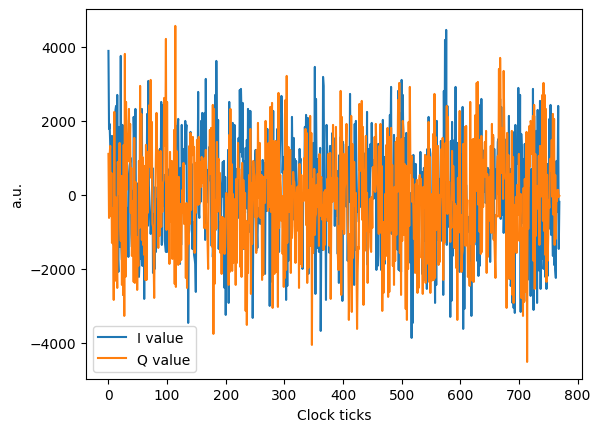

In [10]:
iq_list = X_e_test_board[0].reshape(1, 2, -1)
print(iq_list.shape)

# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value")
    plt.plot(iq[1], label="Q value")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
# plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

In [11]:
y_g_thresh_pred = model.predict(X_g_test_board[:,START_WINDOW*2:END_WINDOW*2])
y_e_thresh_pred = model.predict(X_e_test_board[:,START_WINDOW*2:END_WINDOW*2])

In [12]:
logit_g_errors = 0
logit_e_errors = 0

test_g_size = y_g_thresh_pred.shape[0]
for i in range(test_g_size):
    mismatch = y_g_thresh_pred[i] != 0
    if (mismatch):
        logit_g_errors = logit_g_errors + 1

test_e_size = y_e_thresh_pred.shape[0]
for i in range(test_e_size):
    mismatch = y_e_thresh_pred[i] != 1
    if (mismatch):
        logit_e_errors = logit_e_errors + 1

In [13]:
logit_g_error_rate = (logit_g_errors * 100.) / test_g_size
acccuracy_g = 100. - logit_g_error_rate
print('Logit errors (ground): {:d}/{:d} ({:.2f}%)'.format(logit_g_errors, test_g_size, logit_g_error_rate))
print('Accuracy     (ground): {:.2f}%'.format(acccuracy_g))

Logit errors (ground): 91/5000 (1.82%)
Accuracy     (ground): 98.18%


In [14]:
logit_e_error_rate = (logit_e_errors * 100.) / test_e_size
acccuracy_e = 100. - logit_e_error_rate
print('Logit errors (excited): {:d}/{:d} ({:.2f}%)'.format(logit_e_errors, test_e_size, logit_e_error_rate))
print('Accuracy     (excited): {:.2f}%'.format(acccuracy_e))

Logit errors (excited): 349/5000 (6.98%)
Accuracy     (excited): 93.02%


In [15]:
test_size = test_g_size + test_e_size
logit_errors = logit_g_errors + logit_e_errors
logit_error_rate = (logit_errors * 100.) / test_size
acccuracy = 100. - logit_error_rate
print('Logit errors (average): {:d}/{:d} ({:.2f}%)'.format(logit_errors, test_size, logit_error_rate))
print('Accuracy     (average): {:.2f}%'.format(acccuracy))

Logit errors (average): 440/10000 (4.40%)
Accuracy     (average): 95.60%


#### Shifted windows

In [16]:
SHIFT_OFFSET = 1
SHIFT_L_OR_R = 'R' #'R'
PAD = 'zero' # 'noise' # 'noise'
NOISE_LO = -4
NOISE_HI = 4

In [17]:
def l_shift_data_zero_padded(X, start, end, offset):
    extended_X = np.pad(X, pad_width=((0, 0), (0, offset*2)), mode='constant', constant_values=0)
    return extended_X[:,(start+offset)*2:(end+offset)*2]

def r_shift_data_zero_padded(X, start, end, offset):
    extended_X = np.pad(X, pad_width=((0, 0), (offset*2, 0)), mode='constant', constant_values=0)
    return extended_X[:,start*2:end*2]

def l_shift_data_noise_padded(X, start, end, offset, noise_lo, noise_hi):
    if offset == 0:
        return X[:,(start+offset)*2:(end+offset)*2]
    else:
        num_rows = X.shape[0]
        noise = np.random.uniform(noise_lo, noise_hi, size=(num_rows*offset*2)).astype(int)
        noise = noise.reshape(-1, offset*2)
        return np.hstack((X, noise))[:,(start+offset)*2:(end+offset)*2]

def r_shift_data_noise_padded(X, start, end, offset, noise_lo, noise_hi):
    if offset == 0:
        return extended_X[:,start*2:end*2]
    else:
        num_rows = X.shape[0]
        noise = np.random.uniform(noise_lo, noise_hi, size=(num_rows*offset*2)).astype(int)
        noise = noise.reshape(-1, offset*2)
        return np.hstack((noise, X))[:,start*2:end*2]

In [18]:
if PAD == 'zero':
    if SHIFT_L_OR_R == 'L':
        shifted_g_data = l_shift_data_zero_padded(X_g_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET)
        shifted_e_data = l_shift_data_zero_padded(X_e_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET)
    else: # R
        shifted_g_data = r_shift_data_zero_padded(X_g_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET)
        shifted_e_data = r_shift_data_zero_padded(X_e_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET)
else: # 'noise'
    if SHIFT_L_OR_R == 'L':
        shifted_g_data = l_shift_data_noise_padded(X_g_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET, NOISE_LO, NOISE_HI)
        shifted_e_data = l_shift_data_noise_padded(X_e_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET, NOISE_LO, NOISE_HI)
    else: # R
        shifted_g_data = r_shift_data_noise_padded(X_g_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET, NOISE_LO, NOISE_HI)
        shifted_e_data = r_shift_data_noise_padded(X_e_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET, NOISE_LO, NOISE_HI)

In [19]:
y_g_qkeras_pred = model.predict(shifted_g_data)
y_e_qkeras_pred = model.predict(shifted_e_data)

In [20]:
logit_g_errors = 0
logit_e_errors = 0

test_g_size = y_g_qkeras_pred.shape[0]
for i in range(test_g_size):
    mismatch = y_g_qkeras_pred[i] != 0
    if (mismatch):
        logit_g_errors = logit_g_errors + 1

test_e_size = y_e_qkeras_pred.shape[0]
for i in range(test_e_size):
    mismatch = y_e_qkeras_pred[i] != 1
    if (mismatch):
        logit_e_errors = logit_e_errors + 1

In [21]:
logit_g_error_rate = (logit_g_errors * 100.) / test_g_size
acccuracy_g = 100. - logit_g_error_rate
print('Logit errors (ground): {:d}/{:d} ({:.2f}%)'.format(logit_g_errors, test_g_size, logit_g_error_rate))
print('Accuracy     (ground): {:.2f}%'.format(acccuracy_g))

Logit errors (ground): 92/5000 (1.84%)
Accuracy     (ground): 98.16%


In [22]:
logit_e_error_rate = (logit_e_errors * 100.) / test_e_size
acccuracy_e = 100. - logit_e_error_rate
print('Logit errors (excited): {:d}/{:d} ({:.2f}%)'.format(logit_e_errors, test_e_size, logit_e_error_rate))
print('Accuracy     (excited): {:.2f}%'.format(acccuracy_e))

Logit errors (excited): 349/5000 (6.98%)
Accuracy     (excited): 93.02%


In [23]:
test_size = test_g_size + test_e_size
logit_errors = logit_g_errors + logit_e_errors
logit_error_rate = (logit_errors * 100.) / test_size
acccuracy = 100. - logit_error_rate
print('Logit errors (average): {:d}/{:d} ({:.2f}%)'.format(logit_errors, test_size, logit_error_rate))
print('Accuracy     (average): {:.2f}%'.format(acccuracy))

Logit errors (average): 441/10000 (4.41%)
Accuracy     (average): 95.59%


#### Shifted windows (swiping)

Get the original testing traces for both ground and excited; each trace is 770 cycles = 770 I/Q couples long; shift left (or right) one clock cycle at a time the ground and excited traces; run prediction and collect accuracy.

In [24]:
accuracy_swipe_l = np.array([])
accuracy_g_swipe_l = np.array([])
accuracy_e_swipe_l = np.array([])

accuracy_swipe_r = np.array([])
accuracy_g_swipe_r = np.array([])
accuracy_e_swipe_r = np.array([])

# Swipe and shift left
for SHIFT_OFFSET in range(0,770):

    if PAD == 'zero':
        shifted_g_data = l_shift_data_zero_padded(X_g_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET)
        shifted_e_data = l_shift_data_zero_padded(X_e_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET)
    else: # 'noise'
        shifted_g_data = l_shift_data_noise_padded(X_g_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET, NOISE_LO, NOISE_HI)
        shifted_e_data = l_shift_data_noise_padded(X_e_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET, NOISE_LO, NOISE_HI)

    print('L G {}'.format(SHIFT_OFFSET), end=' ', flush=True)
    y_g_qkeras_pred = model.predict(shifted_g_data)
    print('L E {}'.format(SHIFT_OFFSET), end=' ', flush=True)
    y_e_qkeras_pred = model.predict(shifted_e_data)
    
    logit_g_errors = 0
    logit_e_errors = 0
    
    test_g_size = y_g_qkeras_pred.shape[0]
    for i in range(test_g_size):
        mismatch = y_g_qkeras_pred[i] != 0
        if (mismatch):
            logit_g_errors = logit_g_errors + 1
    
    test_e_size = y_e_qkeras_pred.shape[0]
    for i in range(test_e_size):
        mismatch = y_e_qkeras_pred[i] != 1
        if (mismatch):
            logit_e_errors = logit_e_errors + 1
    
    logit_g_error_rate = (logit_g_errors * 100.) / test_g_size
    acccuracy_g = 100. - logit_g_error_rate
    #print('Logit errors (ground): {:d}/{:d} ({:.2f}%)'.format(logit_g_errors, test_g_size, logit_g_error_rate))
    #print('Accuracy     (ground): {:.2f}%'.format(acccuracy_g))
    
    logit_e_error_rate = (logit_e_errors * 100.) / test_e_size
    acccuracy_e = 100. - logit_e_error_rate
    #print('Logit errors (excited): {:d}/{:d} ({:.2f}%)'.format(logit_e_errors, test_e_size, logit_e_error_rate))
    #print('Accuracy     (excited): {:.2f}%'.format(acccuracy_e))
    
    test_size = test_g_size + test_e_size
    logit_errors = logit_g_errors + logit_e_errors
    logit_error_rate = (logit_errors * 100.) / test_size
    acccuracy = 100. - logit_error_rate
    #print('Logit errors (average): {:d}/{:d} ({:.2f}%)'.format(logit_errors, test_size, logit_error_rate))
    #print('Accuracy     (average): {:.2f}%'.format(acccuracy))

    accuracy_swipe_l = np.append(accuracy_swipe_l, acccuracy)
    accuracy_e_swipe_l = np.append(accuracy_e_swipe_l, acccuracy_e)
    accuracy_g_swipe_l = np.append(accuracy_g_swipe_l, acccuracy_g)

# Swipe and shift right
for SHIFT_OFFSET in range(0,770):

    if PAD == 'zero':
        shifted_g_data = r_shift_data_zero_padded(X_g_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET)
        shifted_e_data = r_shift_data_zero_padded(X_e_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET)
    else: # 'noise'
        shifted_g_data = r_shift_data_noise_padded(X_g_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET, NOISE_LO, NOISE_HI)
        shifted_e_data = r_shift_data_noise_padded(X_e_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET, NOISE_LO, NOISE_HI)

    y_g_qkeras_pred = model.predict(shifted_g_data)
    y_e_qkeras_pred = model.predict(shifted_e_data)
    
    logit_g_errors = 0
    logit_e_errors = 0
    
    test_g_size = y_g_qkeras_pred.shape[0]
    for i in range(test_g_size):
        mismatch = y_g_qkeras_pred[i] != 0
        if (mismatch):
            logit_g_errors = logit_g_errors + 1
    
    test_e_size = y_e_qkeras_pred.shape[0]
    for i in range(test_e_size):
        mismatch = y_e_qkeras_pred[i] != 1
        if (mismatch):
            logit_e_errors = logit_e_errors + 1
    
    logit_g_error_rate = (logit_g_errors * 100.) / test_g_size
    acccuracy_g = 100. - logit_g_error_rate
    #print('Logit errors (ground): {:d}/{:d} ({:.2f}%)'.format(logit_g_errors, test_g_size, logit_g_error_rate))
    #print('Accuracy     (ground): {:.2f}%'.format(acccuracy_g))
    
    logit_e_error_rate = (logit_e_errors * 100.) / test_e_size
    acccuracy_e = 100. - logit_e_error_rate
    #print('Logit errors (excited): {:d}/{:d} ({:.2f}%)'.format(logit_e_errors, test_e_size, logit_e_error_rate))
    #print('Accuracy     (excited): {:.2f}%'.format(acccuracy_e))
    
    test_size = test_g_size + test_e_size
    logit_errors = logit_g_errors + logit_e_errors
    logit_error_rate = (logit_errors * 100.) / test_size
    acccuracy = 100. - logit_error_rate
    #print('Logit errors (average): {:d}/{:d} ({:.2f}%)'.format(logit_errors, test_size, logit_error_rate))
    #print('Accuracy     (average): {:.2f}%'.format(acccuracy))

    accuracy_swipe_r = np.append(accuracy_swipe_r, acccuracy)
    accuracy_e_swipe_r = np.append(accuracy_e_swipe_r, acccuracy_e)
    accuracy_g_swipe_r = np.append(accuracy_g_swipe_r, acccuracy_g)

L G 0 L E 0 L G 1 L E 1 L G 2 L E 2 L G 3 L E 3 L G 4 L E 4 L G 5 L E 5 L G 6 L E 6 L G 7 L E 7 L G 8 L E 8 L G 9 L E 9 L G 10 L E 10 L G 11 L E 11 L G 12 L E 12 L G 13 L E 13 L G 14 L E 14 L G 15 L E 15 L G 16 L E 16 L G 17 L E 17 L G 18 L E 18 L G 19 L E 19 L G 20 L E 20 L G 21 L E 21 L G 22 L E 22 L G 23 L E 23 L G 24 L E 24 L G 25 L E 25 L G 26 L E 26 L G 27 L E 27 L G 28 L E 28 L G 29 L E 29 L G 30 L E 30 L G 31 L E 31 L G 32 L E 32 L G 33 L E 33 L G 34 L E 34 L G 35 L E 35 L G 36 L E 36 L G 37 L E 37 L G 38 L E 38 L G 39 L E 39 L G 40 L E 40 L G 41 L E 41 L G 42 L E 42 L G 43 L E 43 L G 44 L E 44 L G 45 L E 45 L G 46 L E 46 L G 47 L E 47 L G 48 L E 48 L G 49 L E 49 L G 50 L E 50 L G 51 L E 51 L G 52 L E 52 L G 53 L E 53 L G 54 L E 54 L G 55 L E 55 L G 56 L E 56 L G 57 L E 57 L G 58 L E 58 L G 59 L E 59 L G 60 L E 60 L G 61 L E 61 L G 62 L E 62 L G 63 L E 63 L G 64 L E 64 L G 65 L E 65 L G 66 L E 66 L G 67 L E 67 L G 68 L E 68 L G 69 L E 69 L G 70 L E 70 L G 71 L E 71 L G 72 L E 7

##### Visualize how accuracy changes during the swiping

In [31]:
import matplotlib.pyplot as plt

In [26]:
%matplotlib inline

###### Shift left (excited and ground)

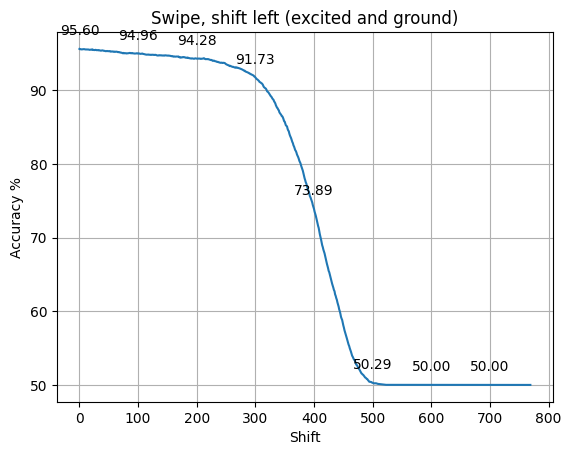

In [27]:
plt.plot(accuracy_swipe_l)
plt.title('Swipe, shift left (excited and ground)')
plt.xlabel('Shift')
plt.ylabel('Accuracy %')

for i, value in enumerate(accuracy_swipe_l):
    if i % 100 == 0:  # Change '3' to your desired interval
        plt.annotate(f'{value:.2f}',  # Format the value to 2 decimal places
                     (i, value),
                     textcoords="offset points",  # How to position the text
                     xytext=(0,10),  # Distance from text to points (x,y)
                     ha='center')  # Horizontal alignment can be left, right or center

plt.grid(True)

plt.show()

###### Shift right (excited and ground)

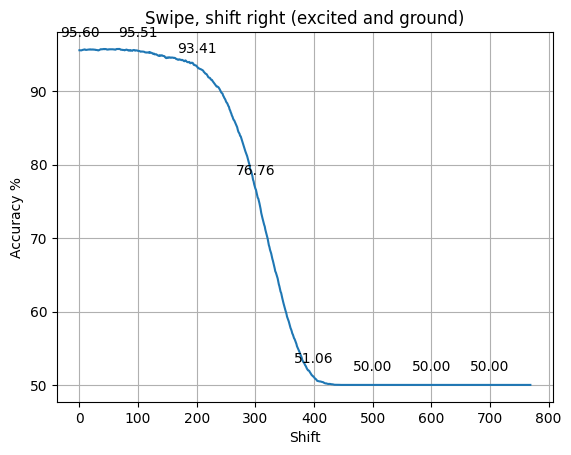

In [28]:
plt.plot(accuracy_swipe_r)
plt.title('Swipe, shift right (excited and ground)')
plt.xlabel('Shift')
plt.ylabel('Accuracy %')

for i, value in enumerate(accuracy_swipe_r):
    if i % 100 == 0:  # Change '3' to your desired interval
        plt.annotate(f'{value:.2f}',  # Format the value to 2 decimal places
                     (i, value),
                     textcoords="offset points",  # How to position the text
                     xytext=(0,10),  # Distance from text to points (x,y)
                     ha='center')  # Horizontal alignment can be left, right or center

plt.grid(True)

plt.show()

###### Shift left (excited)

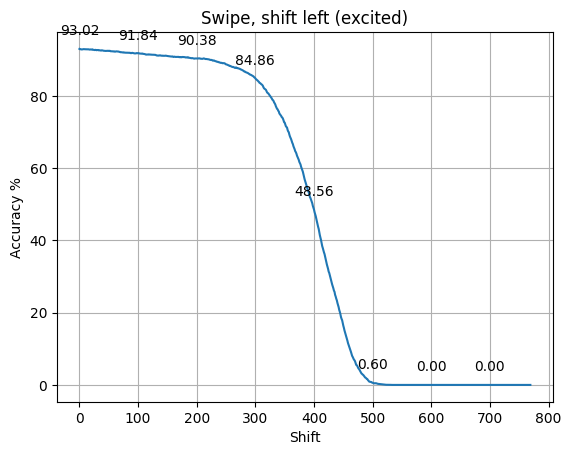

In [29]:
plt.plot(accuracy_e_swipe_l)
plt.title('Swipe, shift left (excited)')
plt.xlabel('Shift')
plt.ylabel('Accuracy %')

for i, value in enumerate(accuracy_e_swipe_l):
    if i % 100 == 0:  # Change '3' to your desired interval
        plt.annotate(f'{value:.2f}',  # Format the value to 2 decimal places
                     (i, value),
                     textcoords="offset points",  # How to position the text
                     xytext=(0,10),  # Distance from text to points (x,y)
                     ha='center')  # Horizontal alignment can be left, right or center

plt.grid(True)

plt.show()

###### Shift rigt (excited)

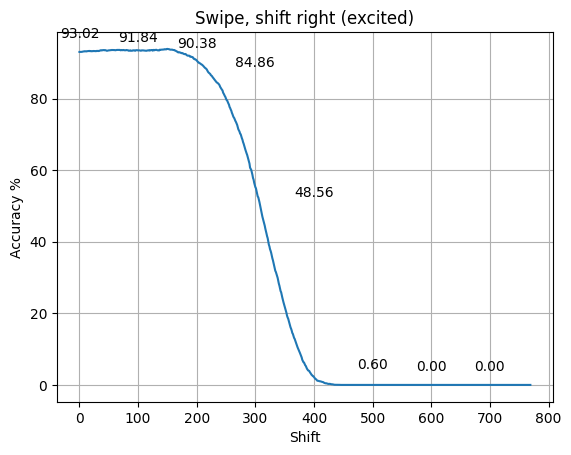

In [30]:
plt.plot(accuracy_e_swipe_r)
plt.title('Swipe, shift right (excited)')
plt.xlabel('Shift')
plt.ylabel('Accuracy %')

for i, value in enumerate(accuracy_e_swipe_l):
    if i % 100 == 0:  # Change '3' to your desired interval
        plt.annotate(f'{value:.2f}',  # Format the value to 2 decimal places
                     (i, value),
                     textcoords="offset points",  # How to position the text
                     xytext=(0,10),  # Distance from text to points (x,y)
                     ha='center')  # Horizontal alignment can be left, right or center

plt.grid(True)

plt.show()